Entropic Regularization of Optimal Transport
============================================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_matlab/) for details about how to install the toolboxes.

This numerical tours exposes the general methodology of regularizing the
optimal transport (OT) linear program using entropy. This allows to
derive fast computation algorithm based on iterative projections
according to a Kulback-Leiber divergence.

In [4]:
from __future__ import division

import numpy as np

import matplotlib.pyplot as plt
import scipy as scp
import pylab as pyl

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Helpers

In [5]:
"""To compute distance matrix"""
def distmat(x,y):
    
    return np.sum(x**2,0)[:,None] + np.sum(y**2,0)[None,:] - 2*x.transpose().dot(y)

"""To Normalise a vector"""
normalize = lambda a: a/np.sum(a)

"""To Compute P"""
def GetP(u,K,v):
    return u*K*(v.T)

def plotp(x, col,plt, scale=200, edgecolors="k"):
  return plt.scatter(x[0,:], x[1,:], s=scale, edgecolors=edgecolors,  c=col, cmap='plasma', linewidths=2)

In [ ]:
N=[400,400]

In [ ]:
x=np.random.rand(2,N[0])-0.5
theta =2*np.pi*np.random.rand(1,N[1])
r=0.8+.2*np.random.rand(1,N[1])
y=np.vstack((r*np.cos(theta),r*np.sin(theta)))

In [ ]:

plt.figure(figsize=(10,10))

plotp(x, 'b',plt)
plotp(y, 'r',plt)

plt.axis("off")
plt.xlim(np.min(y[0,:])-.1,np.max(y[0,:])+.1)
plt.ylim(np.min(y[1,:])-.1,np.max(y[1,:])+.1)

plt.show()

In [ ]:
C = distmat(x,y)

In [ ]:
a = np.ones(N[0])/N[0]
b = np.ones(N[1])/N[1]

In [13]:
import computational_OT

In [ ]:
epsilon = .01
K = np.exp(-C/epsilon)
u=np.ones(N[0])
v = np.ones(N[1])



SOptimizer=computational_OT.Sinkhorn(K,a,b,u,v,epsilon)
out=SOptimizer._update(maxiter=1000)
#
# Plot
plt.figure(figsize = (12,12))

plt.subplot(2,1,1),
plt.title("$||P1 -a||_1$")
plt.plot( np.asarray(out[2]), linewidth = 2)
plt.yscale( 'log')
plt.ylabel("Error in log scale")
plt.xlabel("Number of iterations")
plt.legend(["Sample size: "+str(i)+" and Epsilon="+str(epsilon) for i in N],loc="upper right")

plt.subplot(2,1,2)
plt.title("$||P^T 1 -b||_1$")
plt.plot( np.asarray(out[3]), linewidth = 2)
plt.yscale( 'log')
plt.ylabel("Error in log scale")
plt.xlabel("Number of iterations")
plt.legend(["Sample size: "+str(i)+" and Epsilon="+str(epsilon) for i in N],loc="upper right")
plt.show()

In [ ]:
epsilon = .01
K = np.exp(-C/epsilon)
u=np.ones(N[0])
v = np.ones(N[1])


SOptimizer=computational_OT.Sinkhorn(K,a,b,u,v,epsilon)
outS=SOptimizer._update(maxiter=100)


X = np.hstack( (outS[0],outS[1]) )
X = epsilon*np.log(X)
NOptimizer=computational_OT.NewtonRaphson(X,K,a,b,epsilon)
outN=NOptimizer._update(maxiter=10, debug=False)

In [ ]:
# Plot
plt.figure(figsize = (12,6))

#plt.subplot(2,1,1),
plt.title("$||P1 -a||_1 + ||P^T 1 -b||_1$")
error_sinkhorn = np.asarray(out[2]) + np.asarray(out[3])
error_hybrid   = np.asarray(outS[2]+outN[0]) + np.asarray(outS[3]+outN[1])
plt.plot( error_sinkhorn, label='Sinkhorn for $\epsilon=$' + str(epsilon), linewidth = 2)
plt.plot( error_hybrid,label='Hybrid method for $\epsilon=$'+ str(epsilon), linewidth = 2)
plt.xlabel("Number of iterations")
plt.ylabel("Error in log-scale")
plt.legend()
plt.yscale( 'log')
plt.show()

In [ ]:
P = np.dot(np.dot(np.diag(outS[0]),K),np.diag(outS[1]))
Q1 = np.sort(P, axis=0)
Q2 = np.sort(P, axis=1)

plt.figure()
plt.imshow(P);
plt.figure()
plt.imshow(Q1);
plt.figure()
plt.imshow(Q2);

## Experiments for different epsilons

In [ ]:


epsilons=[0.01,0.02,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
n=len(epsilons)
outS={}
outN={}
P={}
Q1={}
Q2={}
for i in range(n):
    K = np.exp(-C/epsilons[i])
    u=np.ones(N[0])
    v=np.ones(N[1])

    SOptimizer=computational_OT.Sinkhorn(K,a,b,u,v,epsilons[i])
    out1=SOptimizer._update(maxiter=100)
    outS[i]=out1

    X = np.hstack( (outS[i][0],outS[i][1]) )
    X = epsilons[i]*np.log(X)
    NOptimizer=computational_OT.NewtonRaphson(X,K,a,b,epsilons[i])
    out2=NOptimizer._update(maxiter=10, debug=False)
    outN[i]=out2
    
    
    P[i] = np.dot(np.dot(np.diag(out1[0]),K),np.diag(out1[1]))
    Q1[i] = np.sort(P[i], axis=0)
    Q2[i] = np.sort(P[i], axis=1)

    plt.title("P histogram for epsilon: "+str(epsilons[i]))
    plt.hist( P[i].flatten(), 20)
    
    plt.xscale( 'log')
    plt.yscale( 'log')
    plt.show()
    
    fig,ax=plt.subplots(figsize=(20,5),nrows=1,ncols=3)
    ax[0].set_title("P and e: "+ str(epsilons[i]))
    ax[0].imshow(P[i]);
    ax[1].set_title("Q1 and e: "+ str(epsilons[i]))
    ax[1].imshow(Q1[i]);
    ax[2].set_title("Q2 and e: "+ str(epsilons[i]))
    ax[2].imshow(Q2[i]);
    plt.show()
    
    fig,ax=plt.subplots(figsize=(20,5),nrows=1,ncols=4)
    P_xx = np.dot(P[i], P[i].T)
    P_yy = np.dot(P[i].T, P[i])
    ax[0].set_title("P_xx and e: "+str(epsilons[i]))
    ax[0].imshow(P_xx)
    ax[1].set_title("P_yy and e: "+str(epsilons[i]))
    ax[1].imshow(P_yy)


    ax[2].set_title("P_xx flattened and e: "+str(epsilons[i]))
    ax[2].hist( P_xx.flatten(), 20, cumulative=False)
    ax[2].set_xscale("log")
    ax[2].set_yscale("log")
    
    ax[3].set_title("P_yy flattened and e: "+str(epsilons[i]))
    ax[3].hist( P_yy.flatten(), 20, cumulative=False)
    ax[3].set_xscale("log")
    ax[3].set_yscale("log")
    plt.show()

    print("\n \n")
    

## Cuthill Mckee

In [ ]:
cutoff_x=[1e-7,1e-7,1e-7,1e-9,1e-9,1e-9,1e-9,1e-9,1e-9,1e-8,1e-8,1e-8]
cutoff_y=[1e-10,1e-9,1e-8,1e-9,1e-9,1e-9,1e-9,1e-8,1e-8,1e-8,1e-8,1e-8]
for i in range(n):
    CuthillMckee=computational_OT._Expcuthill_mckee(P[i])
    CuthillMckee._evaluate(cut_offx=cutoff_x[i],cut_offy=cutoff_y[i],epsilon=epsilons[i])


## Errors for different epsilons

In [ ]:
# Plot
plt.figure(figsize = (15,6))

#plt.subplot(2,1,1),
plt.title("$||P1 -a||_1 + ||P^T 1 -b||_1$")
for i in range(n):
    error_hybrid   = np.asarray(outS[i][2]+outN[i][0]) + np.asarray(outS[i][3]+outN[i][1])
    plt.plot( error_hybrid,label='Hybrid method for $\epsilon=$'+ str(epsilons[i]), linewidth = 2)

plt.xlabel("Number of iterations")
plt.ylabel("Error in log-scale")
plt.legend()
plt.yscale( 'log')
plt.show()

## Nested Disection

### ANNULUS

In [6]:
N=[400,400]

### Sampled Annulus

In [7]:
theta = 2*np.pi*np.random.rand(1,N[1])
r = .8 + .2*np.random.rand(1,N[1])
y = np.vstack((np.cos(theta)*r,np.sin(theta)*r))

### Rotated Annulus

In [8]:
x=np.vstack((np.zeros(N[0]),np.zeros(N[0])))
x[0][N[0]-1]=y[0][0]
x[1][N[0]-1]=y[1][0]
for i in range(N[0]-1):
    x[0][i]=y[0][i+1]
    x[1][i]=y[1][i+1]

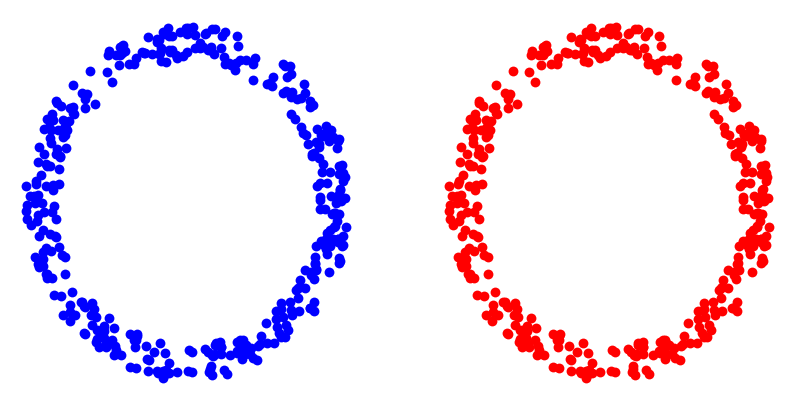

In [9]:
_,ax=plt.subplots(figsize=(10,5),nrows=1,ncols=2)

plotp(x, 'b',ax[0],scale=50, edgecolors=(0,0,0,0))
plotp(y, 'r',ax[1],scale=50, edgecolors=(0,0,0,0))

ax[0].axis("off")
ax[1].axis("off")

# ax[0].xlim(np.min(x[0,:])-.1,np.max(x[0,:])+.1)
# ax[1].ylim(np.min(y[1,:])-.1,np.max(y[1,:])+.1)

plt.show()

In [10]:
C = distmat(x,y)

# a and b
a = normalize(np.ones(N[0]))
a=a.reshape(a.shape[0],-1)
b = normalize(np.ones(N[1]))
b=b.reshape(b.shape[0],-1)

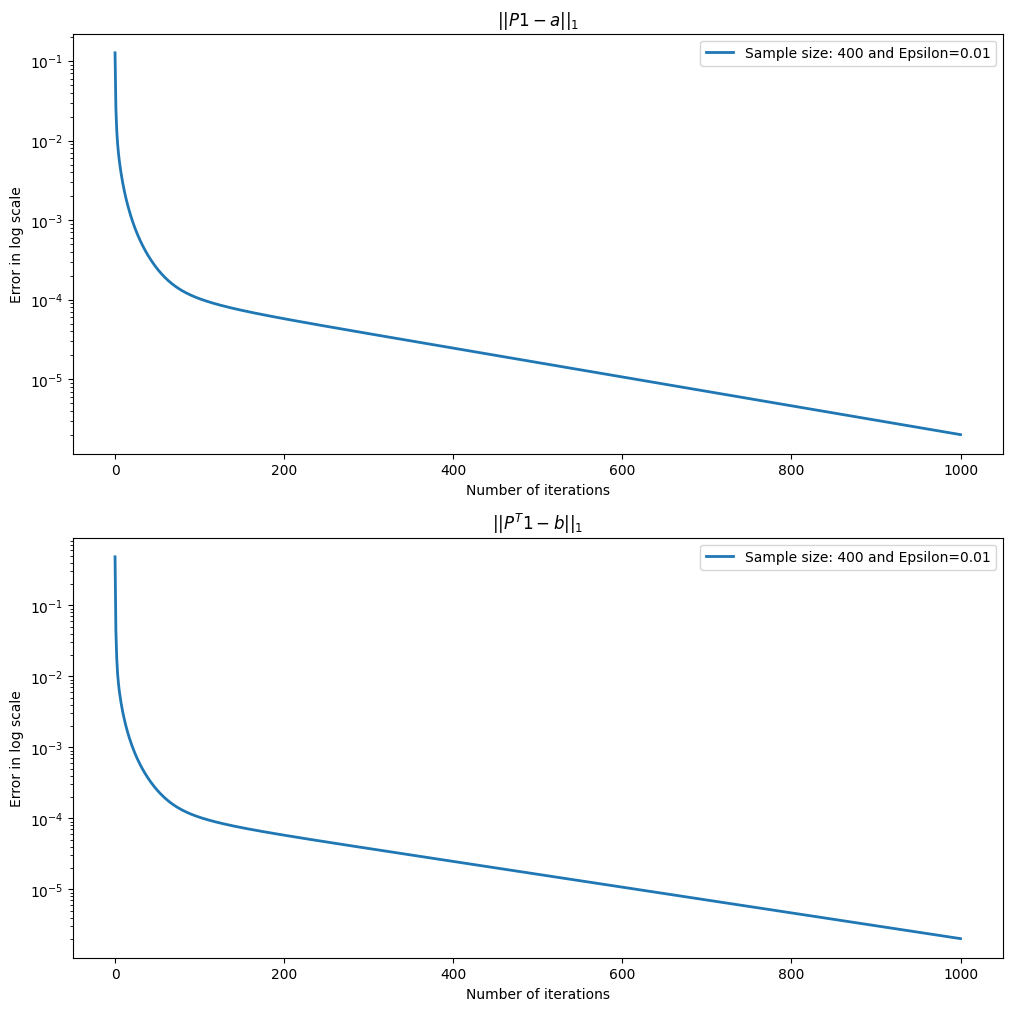

In [15]:
epsilon = .01
K = np.exp(-C/epsilon)
u=np.ones(N[0])
v = np.ones(N[1])


SOptimizer=computational_OT.Sinkhorn(K,a,b,u,v,epsilon)
outS=SOptimizer._update(maxiter=1000)


# Plot
plt.figure(figsize = (12,12))

plt.subplot(2,1,1),
plt.title("$||P1 -a||_1$")
plt.plot( np.asarray(outS[2]), linewidth = 2)
plt.yscale( 'log')
plt.ylabel("Error in log scale")
plt.xlabel("Number of iterations")
plt.legend(["Sample size: "+str(i)+" and Epsilon="+str(epsilon) for i in N],loc="upper right")

plt.subplot(2,1,2)
plt.title("$||P^T 1 -b||_1$")
plt.plot( np.asarray(outS[3]), linewidth = 2)
plt.yscale( 'log')
plt.ylabel("Error in log scale")
plt.xlabel("Number of iterations")
plt.legend(["Sample size: "+str(i)+" and Epsilon="+str(epsilon) for i in N],loc="upper right")
plt.show()

In [26]:
P = outS[0]*K*(outS[1].T)
print(P.shape)

(400, 400)


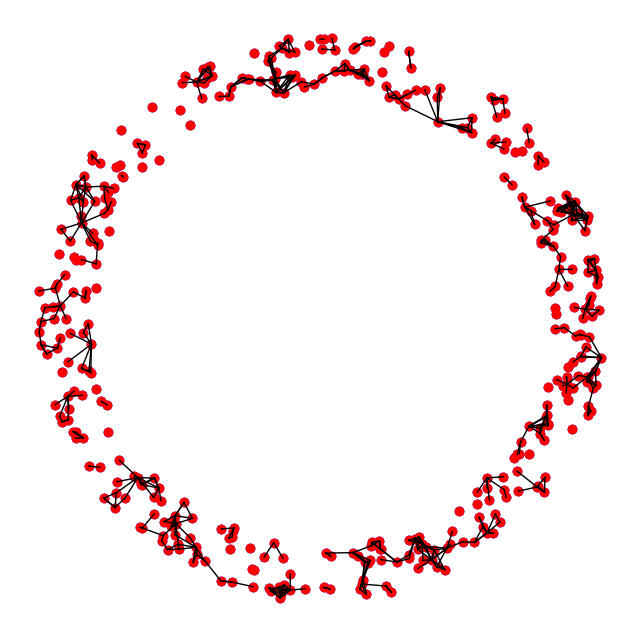

In [36]:
plt.figure(figsize=(8,8))

plotp(x, 'b',plt,scale=50, edgecolors=(0,0,0,0))
plotp(y, 'r',plt,scale=50, edgecolors=(0,0,0,0))


A = P * (P > np.max(P)*.9)
i,j = np.where(A != 0)
plt.plot([x[0,i],y[0,j]],[x[1,i],y[1,j]],'k',lw = 2)

A = P * (P > np.max(P)*.2)
i,j = np.where(A != 0)
plt.plot([x[0,i],y[0,j]],[x[1,i],y[1,j]],'k',lw = 1)

plt.axis("off")
plt.xlim(np.min(y[0,:])-.1,np.max(y[0,:])+.1)
plt.ylim(np.min(y[1,:])-.1,np.max(y[1,:])+.1)

plt.show()